<a href="https://colab.research.google.com/github/renadalahmadi/BigData-and-AI/blob/main/Sentiment_Analysis_for_Financial_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Case : Sentiment Analysis**

This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.


It contains two columns, "Sentiment" and "News Headline". The sentiment can be negative, neutral or positive.

In [2]:
#  Importing Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import string
import sys


from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# - Important NLP downloads 

import nltk
# Download the rule-based sentiment score lexicon(polarity score/word)
nltk.download('vader_lexicon') 
# Download the english stopwords set
nltk.download('stopwords') 
# Wordnet lexical database of semantic relations between words in more than 200 languages
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# adding headings to the columns 
df = pd.read_csv("/content/all-data.csv", encoding="latin-1" , names=['Sentiment', 'News Headline'])

## 1- Simple EDA:

In [5]:
df

,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [9]:
df.shape

(4846, 2)

In [10]:
df.isna().sum()

Sentiment        0
News Headline    0
dtype: int64

In [8]:
df["Sentiment"].value_counts()

neutral     2879
positive    1363
negative     604
Name: Sentiment, dtype: int64

**Note**: From here we can see that the netural class is the largest class comapring it to the pos and neg, we expect the model to perform better in neutral news text.

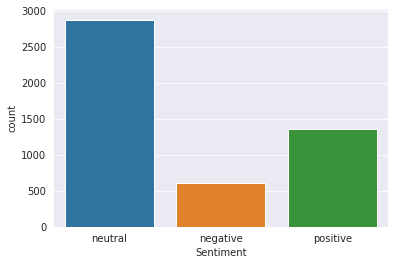

In [12]:
# ploting the counts of each class
sns.set_style("darkgrid")
sns.countplot(df["Sentiment"])

In [13]:
df['length']  = df['News Headline'].str.len()
df

,Sentiment,News Headline,length
0,neutral,"According to Gran , the company has no plans t...",127
1,neutral,Technopolis plans to develop in stages an area...,190
2,negative,The international electronic industry company ...,228
3,positive,With the new production plant the company woul...,206
4,positive,According to the company 's updated strategy f...,203
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,144
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,148
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,108
4844,negative,Net sales of the Paper segment decreased to EU...,226


- Adding the length of news headline for each class for the sake of plotting 

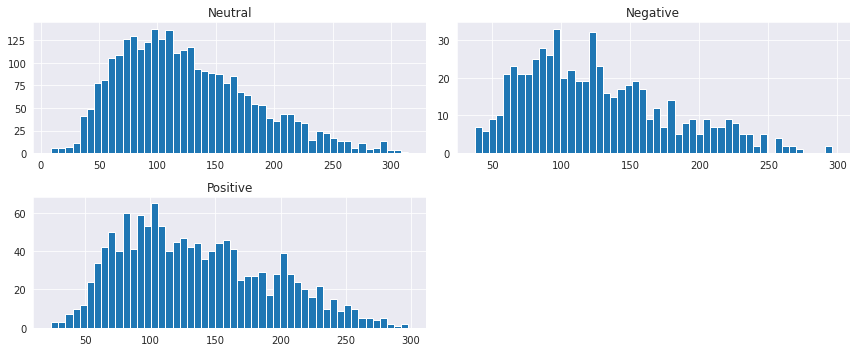

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(2,2,1)
plt.hist(df[df["Sentiment"]=="neutral"]['length'], bins=50)
plt.title("Neutral")

plt.subplot(2,2,2)
plt.hist(df[df["Sentiment"]=="negative"]['length'], bins=50)
plt.title("Negative")

plt.subplot(2,2,3)
plt.hist(df[df["Sentiment"]=="positive"]['length'], bins=50)
plt.title("Positive")

plt.tight_layout()

plt.show()

## 2- Pre-Processing and Cleaning:

**Plan:** 

- Converting to small-case 
- Remove punctuation marks 
- Remove anything that is not a character 
- Remove stop words 


In [39]:
import re
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')

def text_process(text):
    # lowers the text --> no capitalization
    text = str(text).lower()

    # substitute every character that is not a character in the range 'a to z' or 'A to Z' with an space.
    text = re.sub(r"[^a-zA-Z]"," ",text)

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # remove stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [40]:
# applying the funcation for every row in the 'News Headline' col in the df.
df["News Headline"].apply(text_process)

0       [according, gran, company, plans, move, produc...
1       [technopolis, plans, develop, stages, area, le...
2       [international, electronic, industry, company,...
3       [new, production, plant, company, would, incre...
4       [according, company, updated, strategy, years,...
                              ...                        
4841    [london, marketwatch, share, prices, ended, lo...
4842    [rinkuskiai, beer, sales, fell, per, cent, mil...
4843    [operating, profit, fell, eur, mn, eur, mn, in...
4844    [net, sales, paper, segment, decreased, eur, m...
4845    [sales, finland, decreased, january, sales, ou...
Name: News Headline, Length: 4846, dtype: object

## 3- Data Transfromation:

**Plan:** 

- Bag of Words 
- TF-IDF


In [41]:
bagofwords_transformer = CountVectorizer(analyzer=text_process).fit(df["News Headline"])

In [42]:
# list of unique words in the new headline col
print(bagofwords_transformer.vocabulary_)

{'according': 44, 'gran': 3196, 'company': 1440, 'plans': 5864, 'move': 5059, 'production': 6105, 'russia': 6832, 'although': 270, 'growing': 3237, 'technopolis': 7915, 'develop': 1975, 'stages': 7500, 'area': 419, 'less': 4388, 'square': 7481, 'meters': 4873, 'order': 5459, 'host': 3492, 'companies': 1438, 'working': 8852, 'computer': 1496, 'technologies': 7911, 'telecommunications': 7940, 'statement': 7524, 'said': 6865, 'international': 3819, 'electronic': 2320, 'industry': 3687, 'elcoteq': 2310, 'laid': 4263, 'tens': 7967, 'employees': 2363, 'tallinn': 7840, 'facility': 2671, 'contrary': 1610, 'earlier': 2225, 'layoffs': 4323, 'contracted': 1605, 'ranks': 6312, 'office': 5369, 'workers': 8847, 'daily': 1802, 'postimees': 5976, 'reported': 6574, 'new': 5200, 'plant': 5865, 'would': 8866, 'increase': 3649, 'capacity': 1068, 'meet': 4821, 'expected': 2602, 'demand': 1898, 'improve': 3616, 'use': 8438, 'raw': 6337, 'materials': 4756, 'therefore': 8021, 'profitability': 6117, 'updated':

In [58]:
df_bow = bagofwords_transformer.transform(df['Sentiment'])
tfidf_transformer = TfidfTransformer().fit(df_bow)

In [56]:
print(df_bow.shape)

(4846, 8951)


In [60]:
# trying two diffrenet models and checking the performance 
models = {
    "                   Logistic_Regression": LogisticRegression(),
    "              Random_Forest_Classifier": RandomForestClassifier()
}

In [61]:
pipelines={}

X_train, X_test, y_train, y_test = train_test_split(df['News Headline'], df['Sentiment'], test_size=0.3, random_state=101)

In [62]:
def train(X_train, y_train):
    for name, model in models.items():
    
        print(name+"_pipeline created!")
        model_pipeline = Pipeline([
        ('bagofwords', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        (name, model),# train on TF-IDF vectors w/ classifier
        ])
    
        model_pipeline.fit(X_train, y_train)
        print(name+"_pipeline trained!")
    
        pipelines.update({name: model_pipeline})

In [63]:
def test(X_train, X_test, y_train, y_test):
    
    for name, model in pipelines.items():
        print(name)
        print("--------------------"*3)
        print("Testing Accuracy: {:.5f}".format(model.score(X_test, y_test)))
        print("Training Accuracy: {:.5f}".format(model.score(X_train, y_train)))
        print("--------------------"*3)
        print('\n')    

In [64]:
def evalModel(name, model):
    print(name)
    print("\nConfusion Matrix")
    predictions = model.predict(X_test)
    print(confusion_matrix(y_test,predictions))
    print("\nClassifiation Report")
    print(classification_report(y_test,predictions))
    print("==="*40)

In [53]:
pipelines={}
X_train, X_test, y_train, y_test = train_test_split(df['News Headline'], df['Sentiment'], test_size=0.3, random_state=101)

In [65]:
train(X_train, y_train)

                   Logistic_Regression_pipeline created!
                   Logistic_Regression_pipeline trained!
              Random_Forest_Classifier_pipeline created!
              Random_Forest_Classifier_pipeline trained!


In [66]:
test(X_train, X_test, y_train, y_test)

                   Logistic_Regression
------------------------------------------------------------
Testing Accuracy: 0.72765
Training Accuracy: 0.85112
------------------------------------------------------------


              Random_Forest_Classifier
------------------------------------------------------------
Testing Accuracy: 0.72283
Training Accuracy: 0.99823
------------------------------------------------------------




In [67]:
for name, model in pipelines.items():
    evalModel(name, model)

                   Logistic_Regression

Confusion Matrix
[[ 62  77  22]
 [ 13 814  26]
 [ 23 235 182]]

Classifiation Report
              precision    recall  f1-score   support

    negative       0.63      0.39      0.48       161
     neutral       0.72      0.95      0.82       853
    positive       0.79      0.41      0.54       440

    accuracy                           0.73      1454
   macro avg       0.72      0.58      0.61      1454
weighted avg       0.73      0.73      0.70      1454

              Random_Forest_Classifier

Confusion Matrix
[[ 57  62  42]
 [ 18 801  34]
 [ 27 220 193]]

Classifiation Report
              precision    recall  f1-score   support

    negative       0.56      0.35      0.43       161
     neutral       0.74      0.94      0.83       853
    positive       0.72      0.44      0.54       440

    accuracy                           0.72      1454
   macro avg       0.67      0.58      0.60      1454
weighted avg       0.71      0.72      0.70